

https://www.kaggle.com/christofhenkel/keras-baseline

In [1]:
#########################################################################
# CURRENTLY WORKING WITH TENSORFLOW
# 
# PRIORITIES:
# 1. refactor code to better groupings
# 2. where do the functions go
# 3. grab validation data
# 4. test testing data generator
#
# If you are a potential EMPLOYER looking over my code, THANK YOU!
# I love to hear comments and critiques about being a better programmer,
# data engineer, and data scientist.  
# If you found this code useful or learned something, YAY!
# 
# LinkedIn: /in/chris-birch
# Portfolio: www.datapointchris.com/portfolio
# Website: www.datapointchris.com
#
#########################################################################


# ====================================== #
### CURRENT WORKING IMAGE INPUT PARAMS ###

# IMAGES_PER_BATCH
# original images loaded and vstacked
# 16 images = 23 GB
# 8 images is faster

# MODEL_BATCH_SIZE
# how many of the splitter output arrays to process at one time
# 128 = ERROR
# 96 is okay

# SPLITS
# row X col = total images into array
# more splits = larger batch size

### GOOD ###
images_per_batch = 16
split_rows = 20
split_cols = 20
model_batch_size = 96
augmentation = False

### NOT GOOD ###
images_per_batch = 16
split_rows = 20
split_cols = 20
model_batch_size = 96
augmentation = True
# with augmentation 28 GB used memory, going into swap

### NOT GOOD ###
images_per_batch = 16
split_rows = 24
split_cols = 24
model_batch_size = 128
augmentation = True


# ====================================== #


# # ======================================== FOR RUNNING ON THE MACBOOK PRO ====================

### TODO ###
# Check for MacOS environment to enable this automatically

# ## DO THIS BEFORE IMPORTING KERAS OR TENSOR TO USE PLAIDML
# import plaidml.keras
# plaidml.keras.install_backend()

# # Help MacOS be able to use Keras
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# # Gets rid of the processor warning.
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Concatenate, Conv2DTranspose, UpSampling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, TensorBoard
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# from tqdm.keras import TqdmCallback
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import glob
import cv2
import os

import skimage.io

%matplotlib inline


# ============================================================================ #
# ======================= PARAMETERS, PATHS, VARIABLES ======================= #
# ============================================================================ #

train_image_dir = '../images/network_training/build/0/'
train_mask_dir = '../images/network_training/mask/0/'
test_image_dir = '../images/network_training/test/0/'
data_dir = '../data/'

train_images = glob.glob(train_image_dir + '*')
train_filenames = [os.path.basename(x) for x in train_images]

test_images = glob.glob(test_image_dir + '*')
test_filenames = [os.path.basename(x) for x in test_images]


# decrease this number if running out of memory
# works with 4 on 11GB GPU
images_per_batch = 8

# val split from training set
train_val_split_size = .1

seed = 77


# ======Image Splitter Params ====== #

split_rows = 20
split_cols = 20
resize = True
image_resize_width = 4800
image_resize_height = 4800


# ==================================== MODEL PARAMS ==================================== #
epochs = 10
model_batch_size = 64

pretrained_model = True
# set this to any model to load
pretrained_model_path = model_path
model_name = 'datagenmodel'
print_model_summary_on_compile = False
model_path = os.path.join(data_dir, model_name + '.h5')
plot_epoch_val_images = True


# ==================== Callbacks ==================== #

class ValPlotCallback(Callback):

    def on_train_end(self, logs=None):
        print('VALIDATION IMAGES')
        x_val_pred = model.predict(x_val, verbose=1, batch_size=model_batch_size)
        x_val_pred_mask = (x_val_pred > 0.5).astype(np.uint8)
        plot_predictions(original=x_val,
                         predicted=x_val_pred,
                         predicted_mask=x_val_pred_mask,
                         ground_truth=y_val,
                         repeat=True)

validation_plots = ValPlotCallback()
early_stop = EarlyStopping(patience=5, verbose=1)
check_point = ModelCheckpoint(os.path.join(data_dir, model_name + '.hdf5'),
                              save_best_only=True,verbose=1)
tensor_board = TensorBoard(log_dir='../logs/tensorboard/', histogram_freq=1, 
                            write_graph=True, write_grads=False, 
                            write_images=True, embeddings_freq=1, update_freq='epoch')


# ==================== Data Augmentation ==================== #                        
data_augmentation = True
datagen_args = dict(featurewise_center=False,  # set input mean to 0 over the dataset
                             samplewise_center=False,  # set each sample mean to 0
                             featurewise_std_normalization=False,  # divide inputs by std of the dataset
                             samplewise_std_normalization=False,  # divide each input by its std
                             zca_whitening=False,  # apply ZCA whitening
                             zca_epsilon=1e-06,  # epsilon for ZCA whitening
                             # randomly rotate images in the range (degrees, 0 to 180)
                             rotation_range=60,
                             # randomly shift images horizontally (fraction of total width)
                             width_shift_range=0.2,
                             # randomly shift images vertically (fraction of total height)
                             height_shift_range=0.2,
                             shear_range=0.,  # set range for random shear
                             zoom_range=0.,  # set range for random zoom
                             channel_shift_range=0.,  # set range for random channel shifts
                             # set mode for filling points outside the input boundaries
                             fill_mode='nearest',
                             cval=0.,  # value used for fill_mode = "constant"
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True,  # randomly flip images
                             # set rescaling factor (applied before any other transformation)
                             rescale=None,
                             # set function that will be applied on each input
                             preprocessing_function=None,
                             # image data format, either "channels_first" or "channels_last"
                             data_format='channels_last',
                             # fraction of images reserved for validation (strictly between 0 and 1)
                             validation_split=0.0)                        

In [2]:
class ValPlotCallback(Callback):

    def on_train_end(self, logs=None):
        print('VALIDATION IMAGES')
        x_val_pred = model.predict(x_val, verbose=1, batch_size=model_batch_size)
        x_val_pred_mask = (x_val_pred > 0.5).astype(np.uint8)
        plot_predictions(original=x_val,
                         predicted=x_val_pred,
                         predicted_mask=x_val_pred_mask,
                         ground_truth=y_val,
                         repeat=True)

def load_image_as_array(image_name, image_dir, gray=False, resize=False):
    """
    Loads and splits an image
    Returns numpy array
    """
    if gray is False:
        image = cv2.imread(image_dir + image_name).astype(np.uint8)
    else:
        image = cv2.imread(image_dir + image_name, 0).astype(np.uint8)

    image_as_array = image_splitter(image,
                                 num_col_splits=split_cols,
                                 num_row_splits=split_rows,
                                 resize=resize,
                                 resize_height=image_resize_height,
                                 resize_width=image_resize_width)
    return image_as_array

def shape_and_mem(array):
    """Prints the shape and memory size of an array"""
    print(f'Shape: {array.shape}')
    print(f'Size: {round(array.itemsize * array.size / 1024 / 1024 / 1024, 3)} GB')

def image_splitter(image, num_col_splits, num_row_splits, resize=False, resize_width=None, resize_height=None):
    """
    Splits an image into 'num_col_splits' X 'num_row_splits'
    Resize by setting resize=True and specifying 'resize_width' and 'resize_height'
    Returns array of images arranged from left -> right, top -> bottom
    """
    if resize:
        image = cv2.resize(image, (resize_width, resize_height))
    
    width = image.shape[0] 
    height = image.shape[1]
    imglist = []

    for startpoint in np.linspace(0,width,num_col_splits, endpoint=False):
        endpoint=startpoint + (width / num_col_splits)

        for startp2 in np.linspace(0,height,num_row_splits, endpoint=False):
            endp2=startp2 + (height / num_row_splits)

            imglist.append(image[int(startp2):int(endp2), int(startpoint):int(endpoint)]
                        )
    return np.array(imglist)

def image_tester(original):
    """Shows original images in array"""
    for _ in range(4):
        ix = np.random.randint(0, original.shape[0])
        fig, ax = plt.subplots(figsize=(10, 24))

        ax.set_title('Original')
        ax.imshow(original[ix])
        ax.axis('off')

        plt.show()

def image_checker(original, ground_truth):
    """Shows original images in array with their ground truth masks"""
    for _ in range(4):
        ix = np.random.randint(0, original.shape[0])
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 24))

        ax1.set_title('Original')
        ax1.imshow(original[ix])
        ax1.axis('off')

        ax2.set_title('Ground Truth')
        ax2.imshow(np.squeeze(ground_truth[ix]))
        ax2.axis('off')    

        plt.subplots_adjust(wspace=.3, hspace=.3)
        plt.show()

def make_model(pretrained_model=False, model_name=model_name, summary=print_model_summary_on_compile):
    '''
    Creates a new U-Net model
    '''
    inputs = Input((x_train.shape[1], x_train.shape[2], 3))
    s = Lambda(lambda x: x) (inputs) # removed / 255

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    if summary is not None:
        print(summary())
    
    return model

def plot_predictions(original, predicted, predicted_mask, ground_truth=None, repeat=False):
    """
    Plots the original image, predicted image, mask from the predicted image, and ground truth mask.
    ground_truth: None for testing images without masks
    repeat: use the same first 4 images in the dataset for comparison
    """
    ncols_calc = 3
    if ground_truth is not None:
        ncols_calc = 4
        
    
    for i in range(4):
        if repeat:
            ix = i
        else:
            ix = np.random.randint(0, predicted.shape[0])
            
        fig, ax = plt.subplots(ncols=ncols_calc, figsize=(ncols_calc*5, 24))

        ax[0].set_title('Original')
        ax[0].imshow(original[ix])
        ax[0].axis('off')

        ax[1].set_title('Predicted')
        ax[1].imshow(np.squeeze(predicted[ix]))
        ax[1].axis('off')    

        ax[2].set_title('Predicted Mask')
        ax[2].imshow(np.squeeze(predicted_mask[ix]))
        ax[2].axis('off')
        
        if ground_truth is not None:
            ax[3].set_title('Ground Truth')
            ax[3].imshow(np.squeeze(ground_truth[ix]))
            ax[3].axis('off')

        plt.subplots_adjust(wspace=.3, hspace=.3)
        plt.show()

BATCH NUMBER 1 of 23


loadedimages
xlist
8
(400, 240, 240, 3)
ylist
8
(400, 240, 240)
stacked images
x and y
Shape: (3200, 240, 240, 3)
Size: 2.06 GB
None
Shape: (3200, 240, 240, 1)
Size: 0.687 GB
None
xtrain, ytrain, xval, yval
Shape: (2880, 240, 240, 3)
Size: 1.854 GB
None
Shape: (2880, 240, 240, 1)
Size: 0.618 GB
None
Shape: (320, 240, 240, 3)
Size: 0.206 GB
None
Shape: (320, 240, 240, 1)
Size: 0.069 GB
None
Loading Trained Model
Using real-time data augmentation.


W0406 00:57:52.306489 140599253329728 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 45 steps, validate on 320 samples
Epoch 1/10
44/45 [============================>.] - ETA: 0s - loss: 0.2304 - accuracy: 0.8999
Epoch 00001: val_loss improved from inf to 0.19205, saving model to ../data/datagenmodel.hdf5
45/45 [==============================] - 28s 619ms/step - loss: 0.2301 - accuracy: 0.9000 - val_loss: 0.1921 - val_accuracy: 0.9244
Epoch 2/10
44/45 [============================>.] - ETA: 0s - loss: 0.2290 - accuracy: 0.8968
Epoch 00002: val_loss did not improve from 0.19205
45/45 [==============================] - 21s 471ms/step - loss: 0.2277 - accuracy: 0.8974 - val_loss: 0.1982 - val_accuracy: 0.9127
Epoch 3/10
44/45 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9076
Epoch 00003: val_loss improved from 0.19205 to 0.17746, saving model to ../data/datagenmodel.hdf5
45/45 [==============================] - 23s 513ms/step - loss: 0.2073 - accuracy: 0.9079 - val_loss: 0.1775 - val_accuracy: 0.9302
Epoch 4/10
44/45 [=================

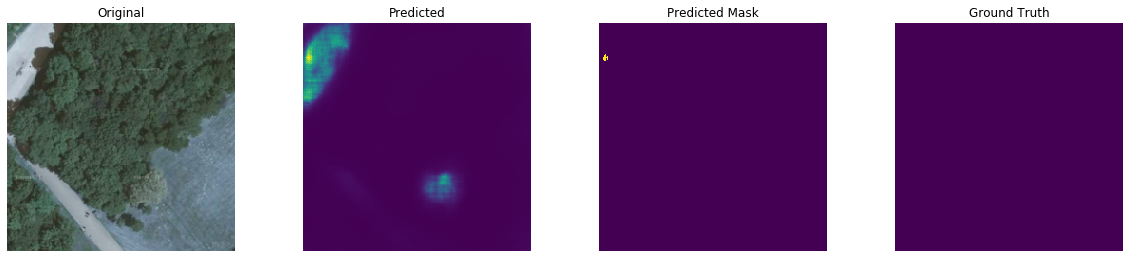

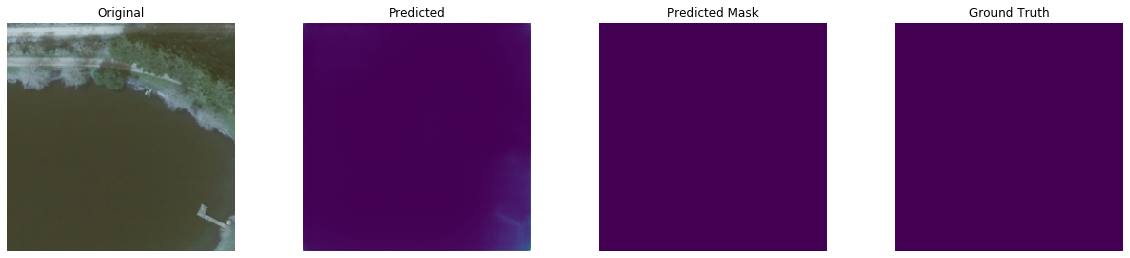

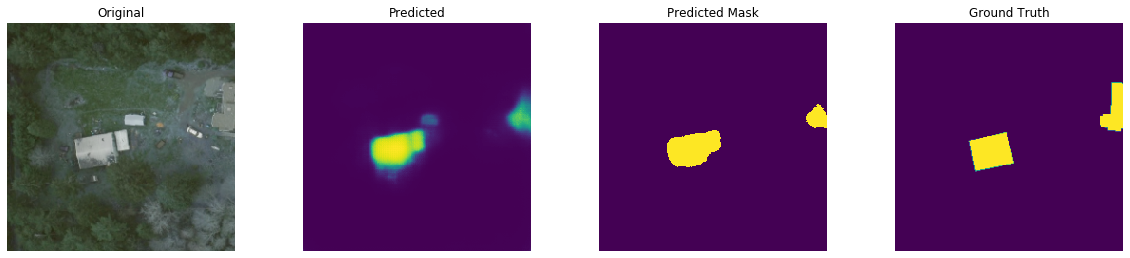

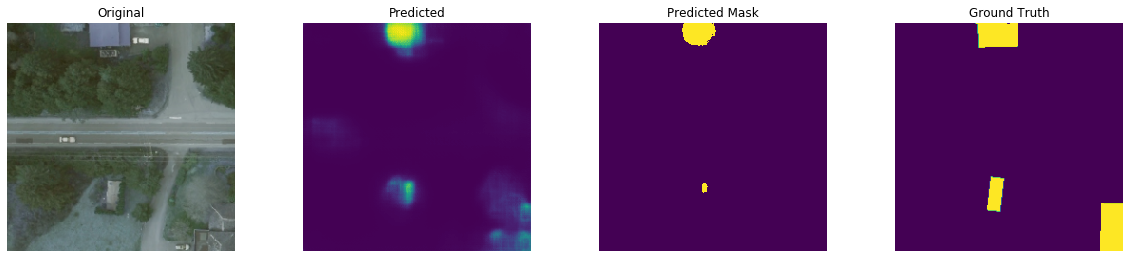

BATCH NUMBER 2 of 23


loadedimages
xlist
8
(400, 240, 240, 3)
ylist
8
(400, 240, 240)
stacked images
x and y
Shape: (3200, 240, 240, 3)
Size: 2.06 GB
None
Shape: (3200, 240, 240, 1)
Size: 0.687 GB
None
xtrain, ytrain, xval, yval
Shape: (2880, 240, 240, 3)
Size: 1.854 GB
None
Shape: (2880, 240, 240, 1)
Size: 0.618 GB
None
Shape: (320, 240, 240, 3)
Size: 0.206 GB
None
Shape: (320, 240, 240, 1)
Size: 0.069 GB
None
Loading Trained Model
Using real-time data augmentation.


W0406 01:02:31.671562 140599253329728 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 45 steps, validate on 320 samples
Epoch 1/10
44/45 [============================>.] - ETA: 0s - loss: 0.2448 - accuracy: 0.8796
Epoch 00001: val_loss did not improve from 0.16206
45/45 [==============================] - 24s 536ms/step - loss: 0.2456 - accuracy: 0.8792 - val_loss: 0.2342 - val_accuracy: 0.8921
Epoch 2/10
44/45 [============================>.] - ETA: 0s - loss: 0.2589 - accuracy: 0.8770
Epoch 00002: val_loss did not improve from 0.16206
45/45 [==============================] - 22s 496ms/step - loss: 0.2585 - accuracy: 0.8771 - val_loss: 0.2615 - val_accuracy: 0.8720
Epoch 3/10
44/45 [============================>.] - ETA: 0s - loss: 0.2393 - accuracy: 0.8838
Epoch 00003: val_loss did not improve from 0.16206
45/45 [==============================] - 22s 488ms/step - loss: 0.2389 - accuracy: 0.8841 - val_loss: 0.2587 - val_accuracy: 0.8732
Epoch 4/10
44/45 [============================>.] - ETA: 0s - loss: 0.2367 - accuracy: 0.8839
Epoch 00004: val_loss did not i

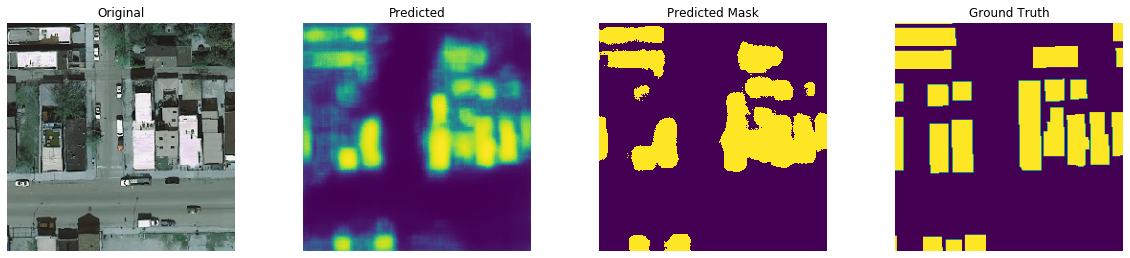

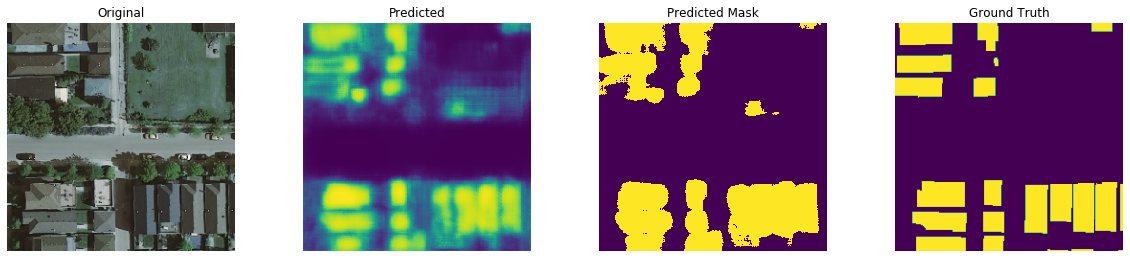

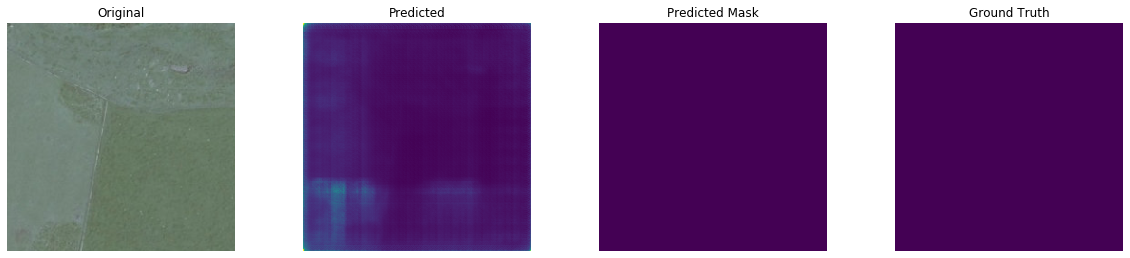

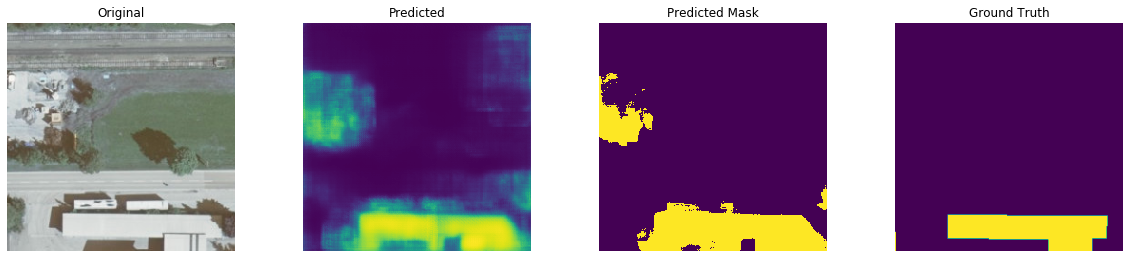

BATCH NUMBER 3 of 23


loadedimages
xlist
8
(400, 240, 240, 3)
ylist
8
(400, 240, 240)
stacked images
x and y
Shape: (3200, 240, 240, 3)
Size: 2.06 GB
None
Shape: (3200, 240, 240, 1)
Size: 0.687 GB
None
xtrain, ytrain, xval, yval
Shape: (2880, 240, 240, 3)
Size: 1.854 GB
None
Shape: (2880, 240, 240, 1)
Size: 0.618 GB
None
Shape: (320, 240, 240, 3)
Size: 0.206 GB
None
Shape: (320, 240, 240, 1)
Size: 0.069 GB
None
Loading Trained Model
Using real-time data augmentation.


W0406 01:07:09.710544 140599253329728 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 45 steps, validate on 320 samples
Epoch 1/10
44/45 [============================>.] - ETA: 0s - loss: 0.2037 - accuracy: 0.9043
Epoch 00001: val_loss did not improve from 0.16206
45/45 [==============================] - 24s 542ms/step - loss: 0.2035 - accuracy: 0.9042 - val_loss: 0.1630 - val_accuracy: 0.9305
Epoch 2/10
44/45 [============================>.] - ETA: 0s - loss: 0.1783 - accuracy: 0.9141
Epoch 00002: val_loss improved from 0.16206 to 0.15599, saving model to ../data/datagenmodel.hdf5
45/45 [==============================] - 23s 502ms/step - loss: 0.1778 - accuracy: 0.9144 - val_loss: 0.1560 - val_accuracy: 0.9325
Epoch 3/10
32/45 [====================>.........] - ETA: 5s - loss: 0.1819 - accuracy: 0.9118

W0406 01:08:11.421847 140599253329728 callbacks.py:1286] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
W0406 01:08:11.426488 140599253329728 callbacks.py:1018] Can save best model only with val_loss available, skipping.


320/320 [==============================] - 1s 4ms/sample


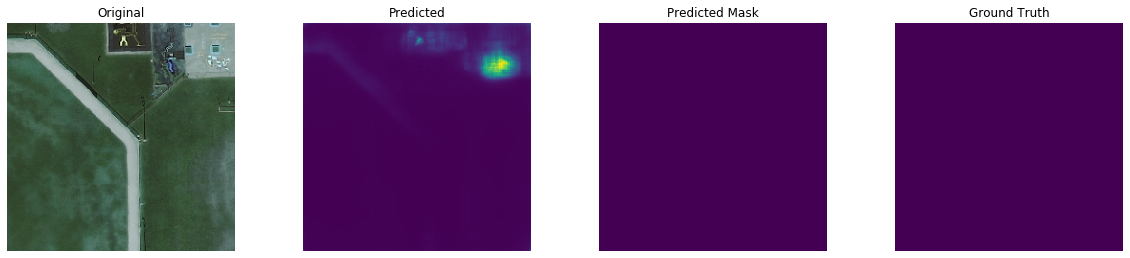

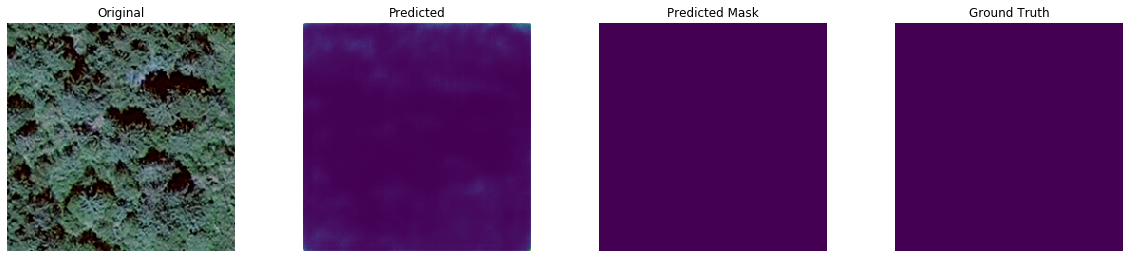

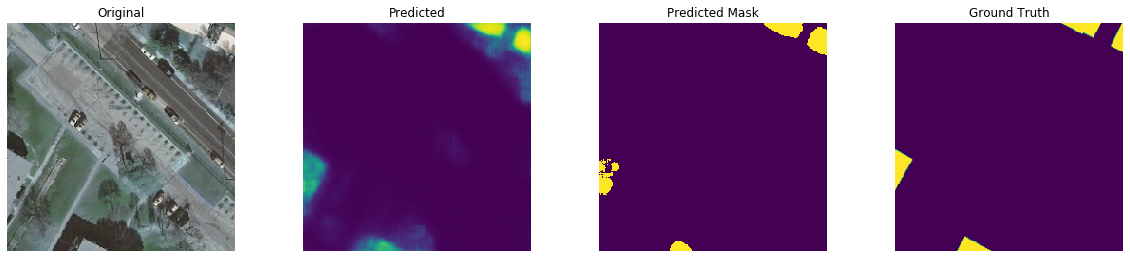

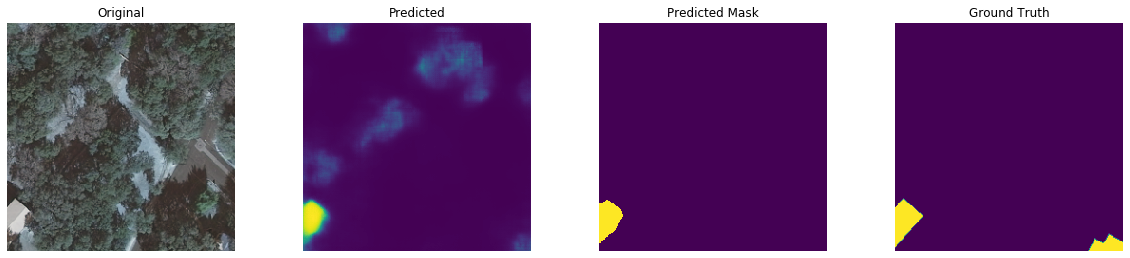

KeyboardInterrupt: 

In [3]:
# ======================= IMAGE PROCESSING ======================= #
# ================================================================ #


# create batch sets of 'images_per_batch' size
training_sets = [train_filenames[i:i + images_per_batch]
                 for i in range(0, len(train_filenames), images_per_batch)]

# load images in batch as a list of arrays
for batch_number, train_set in enumerate(tqdm(training_sets), start=1):
    print(f'BATCH NUMBER {batch_number} of {len(training_sets)}')
    xlist = []
    ylist = []
    for name in tqdm(train_set):
        xlist.append(load_image_as_array(name, train_image_dir, resize=True))
        ylist.append(load_image_as_array(
            name, train_mask_dir, resize=True, gray=True))

    print('loadedimages')
    print('xlist')
    print(len(xlist))
    print(xlist[0].shape)
    print('ylist')
    print(len(ylist))
    print(ylist[0].shape)

    x = (np.vstack(xlist)/255).astype(np.float32)
    y = (np.vstack(ylist)/255).astype(np.float32)
    y = np.expand_dims(y, axis=3)  # grayscale

    print('stacked images')
    print('x and y')
    print(shape_and_mem(x))
    print(shape_and_mem(y))

    x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                      random_state=77,
                                                      test_size=train_val_split_size)
    print('xtrain, ytrain, xval, yval')
    print(shape_and_mem(x_train))
    print(shape_and_mem(y_train))
    print(shape_and_mem(x_val))
    print(shape_and_mem(y_val))

# ================================================================ #
# =========================== TRAINING =========================== #
    
    # load or train model
    if pretrained_model or batch_number > 1:
        print('Loading Trained Model')
        model = load_model(trained_model)
    else:
        print('Creating New Model')
        model = make_model(pretrained_model=pretrained_model,
                           model_name=model_name)
        
    # =================== MODEL PARAMS =================== #
    model_fit_params = dict(batch_size=model_batch_size,
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        verbose=1,
                        steps_per_epoch=x_train.shape[0] // model_batch_size,
                        validation_steps=(x_train.shape[0] // model_batch_size) * train_val_split_size,
                        callbacks=[early_stop, check_point, tensor_board, validation_plots])
        
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(x_train, y_train, **model_fit_params)
    else:
        print('Using real-time data augmentation.')

        image_datagen = ImageDataGenerator(**datagen_args)
        mask_datagen = ImageDataGenerator(**datagen_args)

        # provide the same seed and keyword arguments
        image_datagen.fit(x_train, augment=True, seed=seed)
        mask_datagen.fit(y_train, augment=True, seed=seed)

        image_generator = image_datagen.flow(x_train,
#                                              save_to_dir='../images/augmented/images/',
                                             seed=seed)

        mask_generator = mask_datagen.flow(y_train,
#                                            save_to_dir='../images/augmented/masks/',
                                           seed=seed)
### NOTE ###
# Can I use the validation setting on the image generators and get rid of the train/test split
# then I can feed my images in as generators to the generators and skip the loop
        
        # combine generators into one which yields image and masks
        train_generator = zip(image_generator, mask_generator)

        model.fit(train_generator, **model_fit_params)

    model.save(model_path)

In [4]:
model.save(model_path)

In [5]:
# ================================================================ #
# ========================== VALIDATION ========================== #

x_val_pred = model.predict(x_val, verbose=1, batch_size=model_batch_size)

model.evaluate(x=x_val, y=y_val, batch_size=model_batch_size)

# simple threshold to change to 1/0, mask
x_val_pred_mask = (x_val_pred > 0.5).astype(np.uint8)

320/320 [==============================] - 1s 2ms/sample - loss: 0.1572 - accuracy: 0.9329


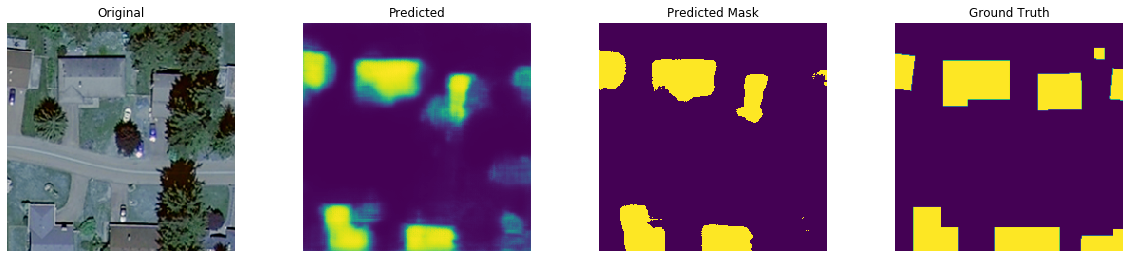

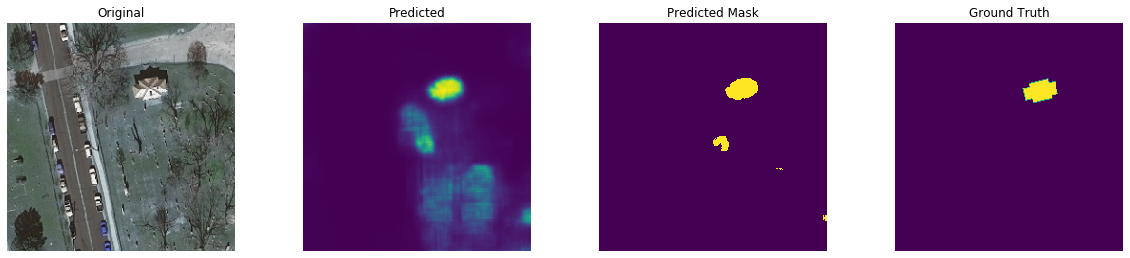

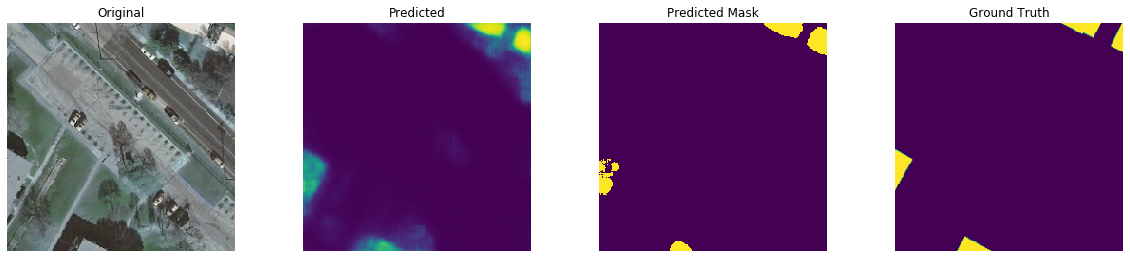

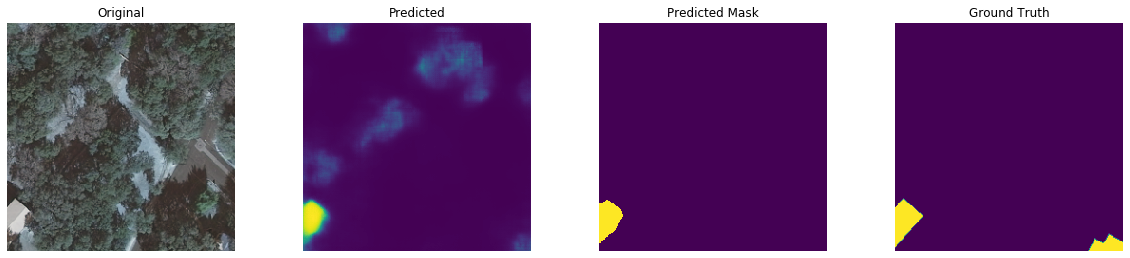

In [6]:
plot_predictions(original=x_val, predicted=x_val_pred,
                 predicted_mask=x_val_pred_mask, ground_truth=y_val)

In [7]:
# model = load_model('../data/testing_model.h5')

In [8]:
# ================================================================ #
# ========================== PREDICTION ========================== #


x_test = [np.array(
    image_splitter(
        cv2.imread(test_image_dir + img_name).astype(np.uint8),
        num_col_splits=split_cols,
        num_row_splits=split_rows,
        resize=resize,
        resize_height=image_resize_height,
        resize_width=image_resize_width
    )
) for img_name in tqdm(test_filenames[:20])]

x_test = (np.vstack(x_test)/255).astype(np.float32)

shape_and_mem(x_test)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(x_test, seed=seed)

y_pred = model.predict(test_generator, verbose=1)

shape_and_mem(y_pred)

y_pred_mask = (y_pred > 0.5).astype(np.uint8)

Shape: (8000, 240, 240, 3)
Size: 5.15 GB
250/250 [==============================] - 18s 73ms/step
Shape: (8000, 240, 240, 1)
Size: 1.717 GB


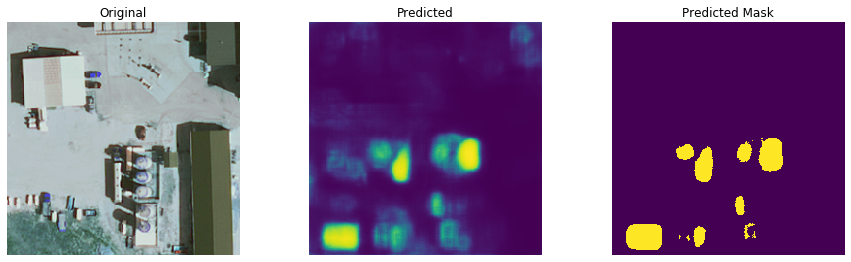

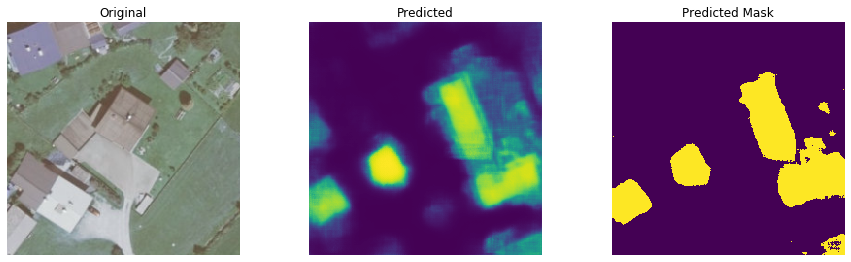

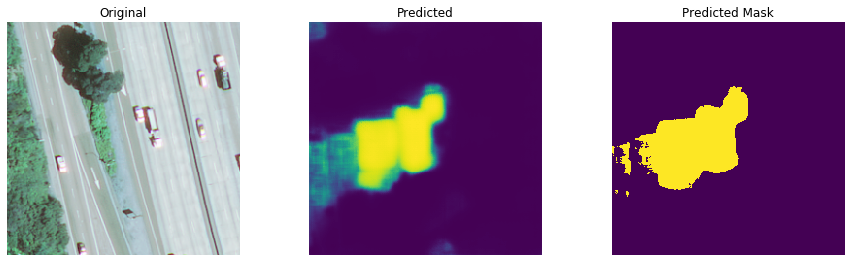

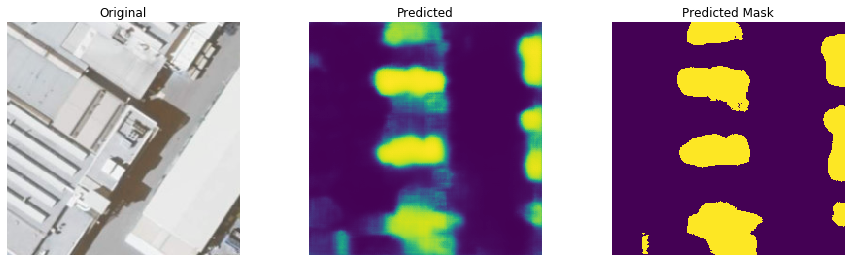

In [9]:
plot_predictions(original=x_test, predicted=y_pred,
                 predicted_mask=y_pred_mask)


# https://www.jeremyjordan.me/evaluating-image-segmentation-models/

# result = cv2.bitwise_and(test_split[0], test_split[0], mask=prediction[0])

# result